In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [85]:
df = pd.read_excel('c:\\Users\\U440845\\Documents\\GitHub\\Miles_Forecasting\\dataset\\Final_KPIs.xlsx', na_values='None')

In [86]:
df.head()

,month,flown miles,rpms,distinct prem (GS + 1K),accrued miles,gross passenger revenue,accrued:redeemed
0,2019-01-01,4730717361,17525531459,22992,24509761414,2.835882e+09,5
1,2019-02-01,9212110701,15576416271,32358,21734038032,2.723044e+09,2
2,2019-03-01,16371796910,20124160307,44459,25208125623,3.167433e+09,2
3,2019-04-01,16582967373,19601173274,42422,26265097065,3.068168e+09,2
4,2019-05-01,19900973419,21003785305,46735,27683273666,3.201879e+09,1


In [87]:
print(df.shape)

(84, 7)


In [88]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   month                    84 non-null     datetime64[us]
 1   flown miles              84 non-null     int64         
 2   rpms                     84 non-null     int64         
 3   distinct prem (GS + 1K)  84 non-null     int64         
 4   accrued miles            84 non-null     int64         
 5   gross passenger revenue  84 non-null     float64       
 6   accrued:redeemed         84 non-null     int64         
dtypes: datetime64[us](1), float64(1), int64(5)
memory usage: 4.7 KB


Adding lags, rolling mean, month index, year index / time step, YoY growth rate

In [89]:
# lags ---> creating lagged features ----> to capture the temporal dependencies
df["flown miles lag_3"]  = df["flown miles"].shift(3)
df["flown miles lag_12"] = df["flown miles"].shift(12)

In [90]:
# rolling mean 3m -----> creating rolling mean features ----> to capture the stability and trend
df["flown miles rolling mean 3"] = df["flown miles"].rolling(window=3).mean()

In [91]:
# Month index with cyclic encoding ----> to capture seasonality -- and to make the model understand that time is cyclic rather than linear
df['month_index'] = df['month'].dt.month
df["year"] = df["month"].dt.year
df['month_sin'] = np.sin(2 * np.pi * df['month_index'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month_index'] / 12)

In [92]:
#  Year index / time step -----> to capture trend ---> to create time aware features
start_year = df['month'].dt.year.min()
start_month = df['month'].dt.month.min()
df['time_step'] = ((df['month'].dt.year - start_year) * 12 + (df['month'].dt.month - start_month))

In [93]:
# YoY Growth Rate (t vs t-12) ----> for normalization and to capture the growth trend in the data
df['flown miles yoy growth'] = ((df['flown miles'] - df['flown miles lag_12']) / df['flown miles lag_12'])
df.loc[df['time_step'] < 12, 'flown miles yoy growth'] = np.nan
df['flown miles yoy growth'] = df['flown miles yoy growth'].clip(-1, 2) # clipping to handle outliers so that the model is not skewed by extreme values

In [94]:
month_yoy_avg = ( df.groupby("month_index")["flown miles yoy growth"].mean().rename("month_yoy_avg_growth"))
df = df.join(month_yoy_avg, on="month_index")

In [95]:
df.head(15)

,month,flown miles,rpms,distinct prem (GS + 1K),accrued miles,gross passenger revenue,accrued:redeemed,flown miles lag_3,flown miles lag_12,flown miles rolling mean 3,month_index,year,month_sin,month_cos,time_step,flown miles yoy growth,month_yoy_avg_growth
0,2019-01-01,4730717361,17525531459,22992,24509761414,2.835882e+09,5,NaN,NaN,NaN,1,2019,5.000000e-01,8.660254e-01,0,NaN,0.654319
1,2019-02-01,9212110701,15576416271,32358,21734038032,2.723044e+09,2,NaN,NaN,NaN,2,2019,8.660254e-01,5.000000e-01,1,NaN,0.457455
2,2019-03-01,16371796910,20124160307,44459,25208125623,3.167433e+09,2,NaN,NaN,1.010487e+10,3,2019,1.000000e+00,6.123234e-17,2,NaN,0.253648
3,2019-04-01,16582967373,19601173274,42422,26265097065,3.068168e+09,2,4.730717e+09,NaN,1.405562e+10,4,2019,8.660254e-01,-5.000000e-01,3,NaN,0.498118
4,2019-05-01,19900973419,21003785305,46735,27683273666,3.201879e+09,1,9.212111e+09,NaN,1.761858e+10,5,2019,5.000000e-01,-8.660254e-01,4,NaN,0.448148
5,2019-06-01,24538924529,22560764124,51602,28419258952,2.853826e+09,1,1.637180e+10,NaN,2.034096e+10,6,2019,1.224647e-16,-1.000000e+00,5,NaN,0.380598
6,2019-07-01,26486003428,23298269589,55008,26288476295,2.843473e+09,1,1.658297e+10,NaN,2.364197e+10,7,2019,-5.000000e-01,-8.660254e-01,6,NaN,0.318172
7,2019-08-01,23773434260,22426328916,53716,31253508496,2.768900e+09,1,1.990097e+10,NaN,2.493279e+10,8,2019,-8.660254e-01,-5.000000e-01,7,NaN,0.344418
8,2019-09-01,18349605650,19016091496,43099,29459033406,2.796124e+09,2,2.453892e+10,NaN,2.286968e+10,9,2019,-1.000000e+00,-1.836970e-16,8,NaN,0.371517
9,2019-10-01,19458366948,19842454072,46333,29912428988,2.972310e+09,2,2.648600e+10,NaN,2.052714e+10,10,2019,-8.660254e-01,5.000000e-01,9,NaN,0.369565


In [96]:
sns.set(style="whitegrid")

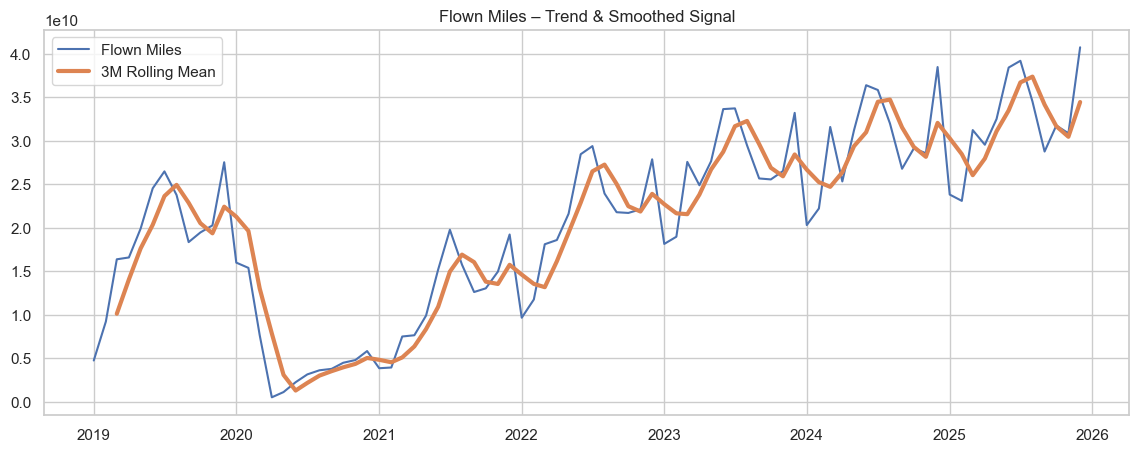

In [97]:
# Target over time (trend + seasonality)
plt.figure(figsize=(14,5))
plt.plot(df['month'], df['flown miles'], label='Flown Miles')
plt.plot(df['month'], df['flown miles rolling mean 3'], label='3M Rolling Mean', linewidth=3)
plt.title('Flown Miles – Trend & Smoothed Signal')
plt.legend()
plt.show()


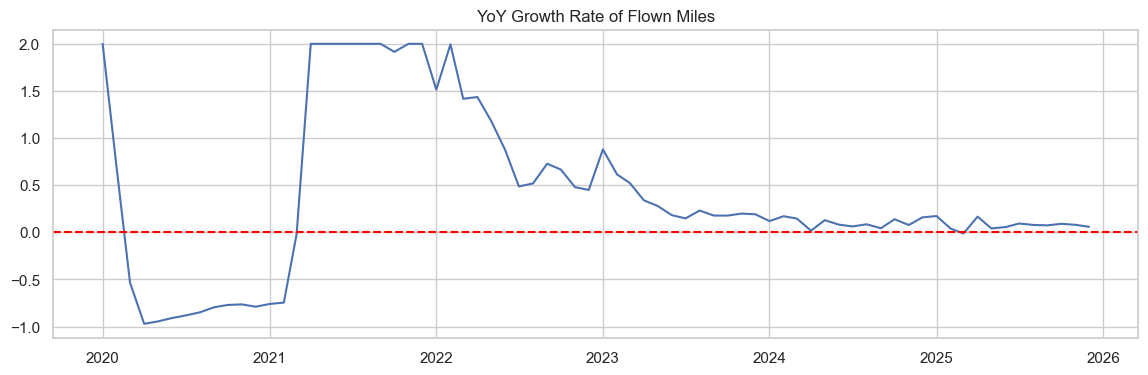

In [98]:
#YoY growth rate over time
plt.figure(figsize=(14,4))
plt.plot(df['month'], df['flown miles yoy growth'])
plt.axhline(0, color='red', linestyle='--')
plt.title('YoY Growth Rate of Flown Miles')
plt.show()

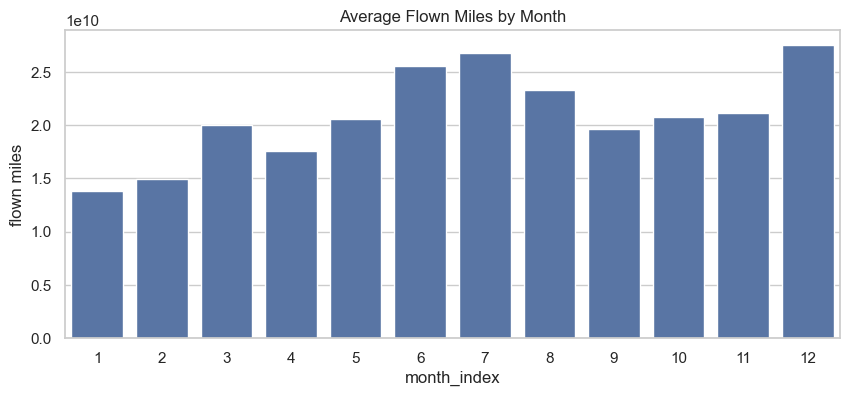

In [99]:
#Average flown miles by month
seasonality = (df.groupby('month_index')['flown miles'].mean().reset_index())
plt.figure(figsize=(10,4))
sns.barplot(x='month_index', y='flown miles', data=seasonality)
plt.title('Average Flown Miles by Month')
plt.show()
#most of the flown miles are in the month of june and july, and dec. 

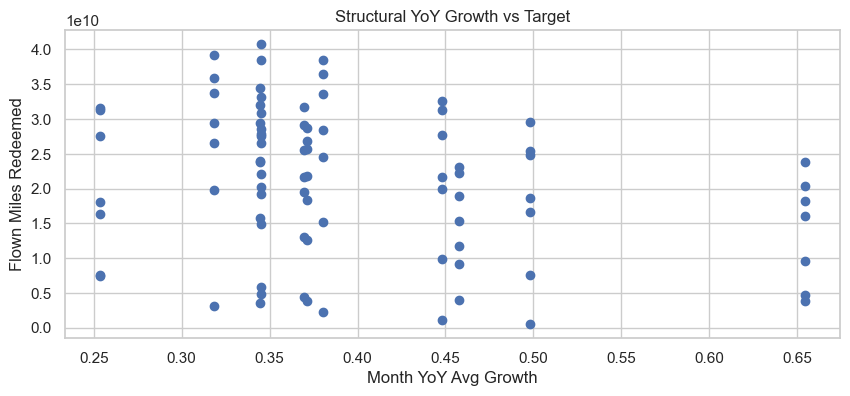

In [100]:
plt.figure(figsize=(10,4))
plt.scatter(df["month_yoy_avg_growth"], df["flown miles"])
plt.xlabel("Month YoY Avg Growth")
plt.ylabel("Flown Miles Redeemed")
plt.title("Structural YoY Growth vs Target")
plt.grid(True)
plt.show()

In [101]:
# Correlation of lags and rolling means with the target variable ---> flown miles
lag_cols = ['flown miles lag_3',
    'flown miles lag_12',
    'flown miles rolling mean 3']
df[lag_cols + ['flown miles']].corr()['flown miles'].sort_values(ascending=False)
#rolling mean 3 has the highest correlation with the target variable suprisingly. ---> this indicates that the short term trend is more important than the long term trend for forecasting flown miles.
#usually we would expect the longer term rolling mean to have a higher correlation, but in this case the 3 month rolling mean is more closely aligned with the target variable
# which suggests that recent trends are more influential in predicting flown miles than longer term trends.

flown miles                   1.000000
flown miles rolling mean 3    0.939355
flown miles lag_3             0.758929
flown miles lag_12            0.605002
Name: flown miles, dtype: float64

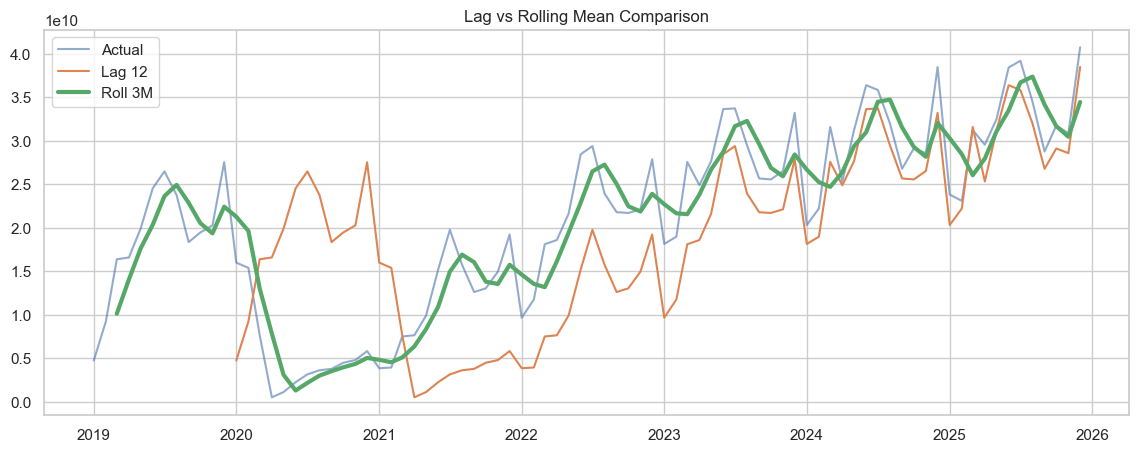

In [106]:
# Visual comparison of lag and rolling mean features with the target variable
plt.figure(figsize=(14,5))
plt.plot(df['month'], df['flown miles'], label='Actual', alpha=0.6)
plt.plot(df['month'], df['flown miles lag_12'], label='Lag 12')
plt.plot(df['month'], df['flown miles rolling mean 3'], label='Roll 3M', linewidth=3)
plt.legend()
plt.title('Lag vs Rolling Mean Comparison')
plt.show()


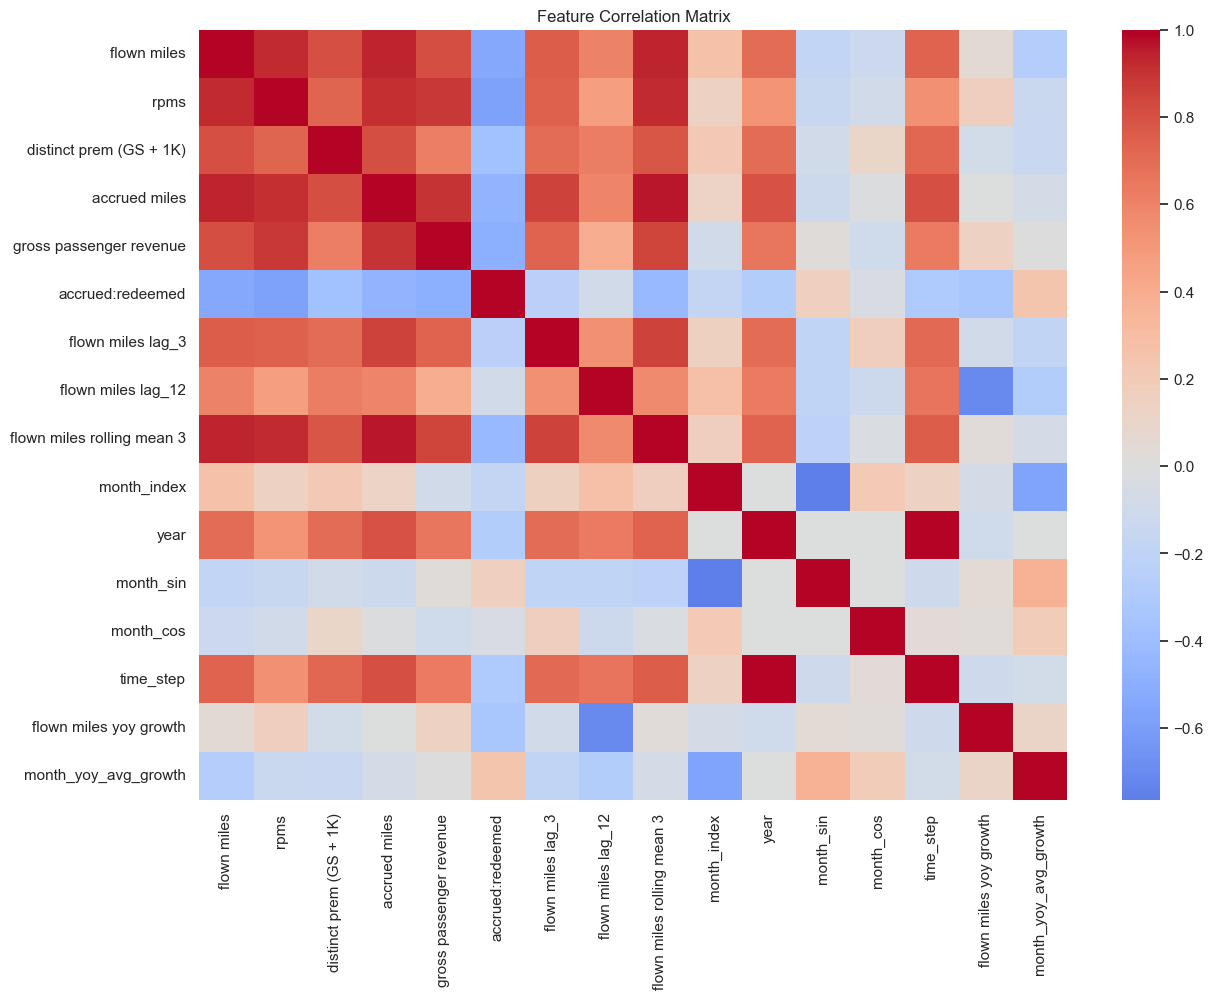

In [103]:
# Correlation matrix of all features to understand relationships and multicollinearity
numeric_cols = df.select_dtypes(include=np.number).columns

plt.figure(figsize=(14,10))
sns.heatmap(
    df[numeric_cols].corr(),
    cmap='coolwarm',
    center=0
)
plt.title('Feature Correlation Matrix')
plt.show()
# the correlation matrix shows that the accrued:redeemed miles ratio has a strong negative correlation with flown miles, which makes sense as higher the ratio, the more miles are being redeemed relative to accrued, which could indicate lower future flown miles.
# the month index and its cyclic transformations (month_sin and month_cos) also show some correlation with flown miles, indicating that seasonality is an important factor in the data.
# we can drop the lag features if we want to simplify the model, as they are less correlated with the target variable compared to the rolling mean features.

In [104]:
df.corr()['flown miles'].sort_values(ascending=False)


flown miles                   1.000000
flown miles rolling mean 3    0.939355
accrued miles                 0.933316
rpms                          0.921654
gross passenger revenue       0.813553
distinct prem (GS + 1K)       0.806431
flown miles lag_3             0.758929
time_step                     0.733208
month                         0.732885
year                          0.702118
flown miles lag_12            0.605002
month_index                   0.268610
flown miles yoy growth        0.052230
month_cos                    -0.128072
month_sin                    -0.185486
month_yoy_avg_growth         -0.272627
accrued:redeemed             -0.540583
Name: flown miles, dtype: float64

In [107]:
cols_to_drop = [
    "rpms",
    "month",
    "year",
    "month_index",
    "flown miles yoy growth"
]
df.drop(columns=cols_to_drop, inplace=True)
df.head()

,flown miles,distinct prem (GS + 1K),accrued miles,gross passenger revenue,accrued:redeemed,flown miles lag_3,flown miles lag_12,flown miles rolling mean 3,month_sin,month_cos,time_step,month_yoy_avg_growth
0,4730717361,22992,24509761414,2.835882e+09,5,NaN,NaN,NaN,0.500000,8.660254e-01,0,0.654319
1,9212110701,32358,21734038032,2.723044e+09,2,NaN,NaN,NaN,0.866025,5.000000e-01,1,0.457455
2,16371796910,44459,25208125623,3.167433e+09,2,NaN,NaN,1.010487e+10,1.000000,6.123234e-17,2,0.253648
3,16582967373,42422,26265097065,3.068168e+09,2,4.730717e+09,NaN,1.405562e+10,0.866025,-5.000000e-01,3,0.498118
4,19900973419,46735,27683273666,3.201879e+09,1,9.212111e+09,NaN,1.761858e+10,0.500000,-8.660254e-01,4,0.448148


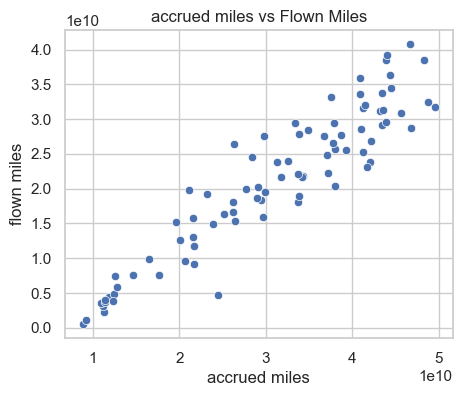

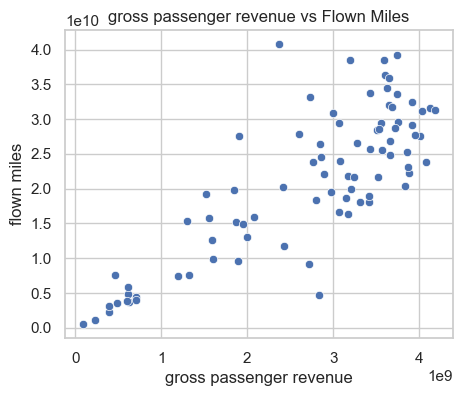

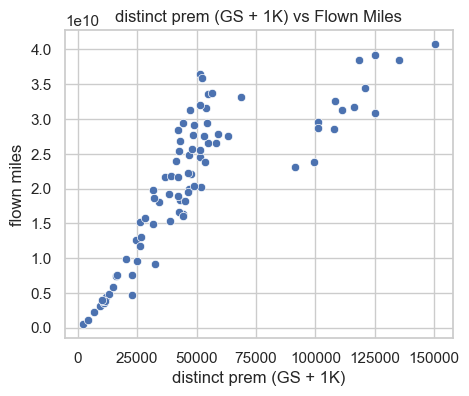

In [108]:
key_features = ['accrued miles', 'gross passenger revenue', 'distinct prem (GS + 1K)']
for col in key_features:
    plt.figure(figsize=(5,4))
    sns.scatterplot(x=df[col], y=df['flown miles'])
    plt.title(f'{col} vs Flown Miles')
    plt.show()

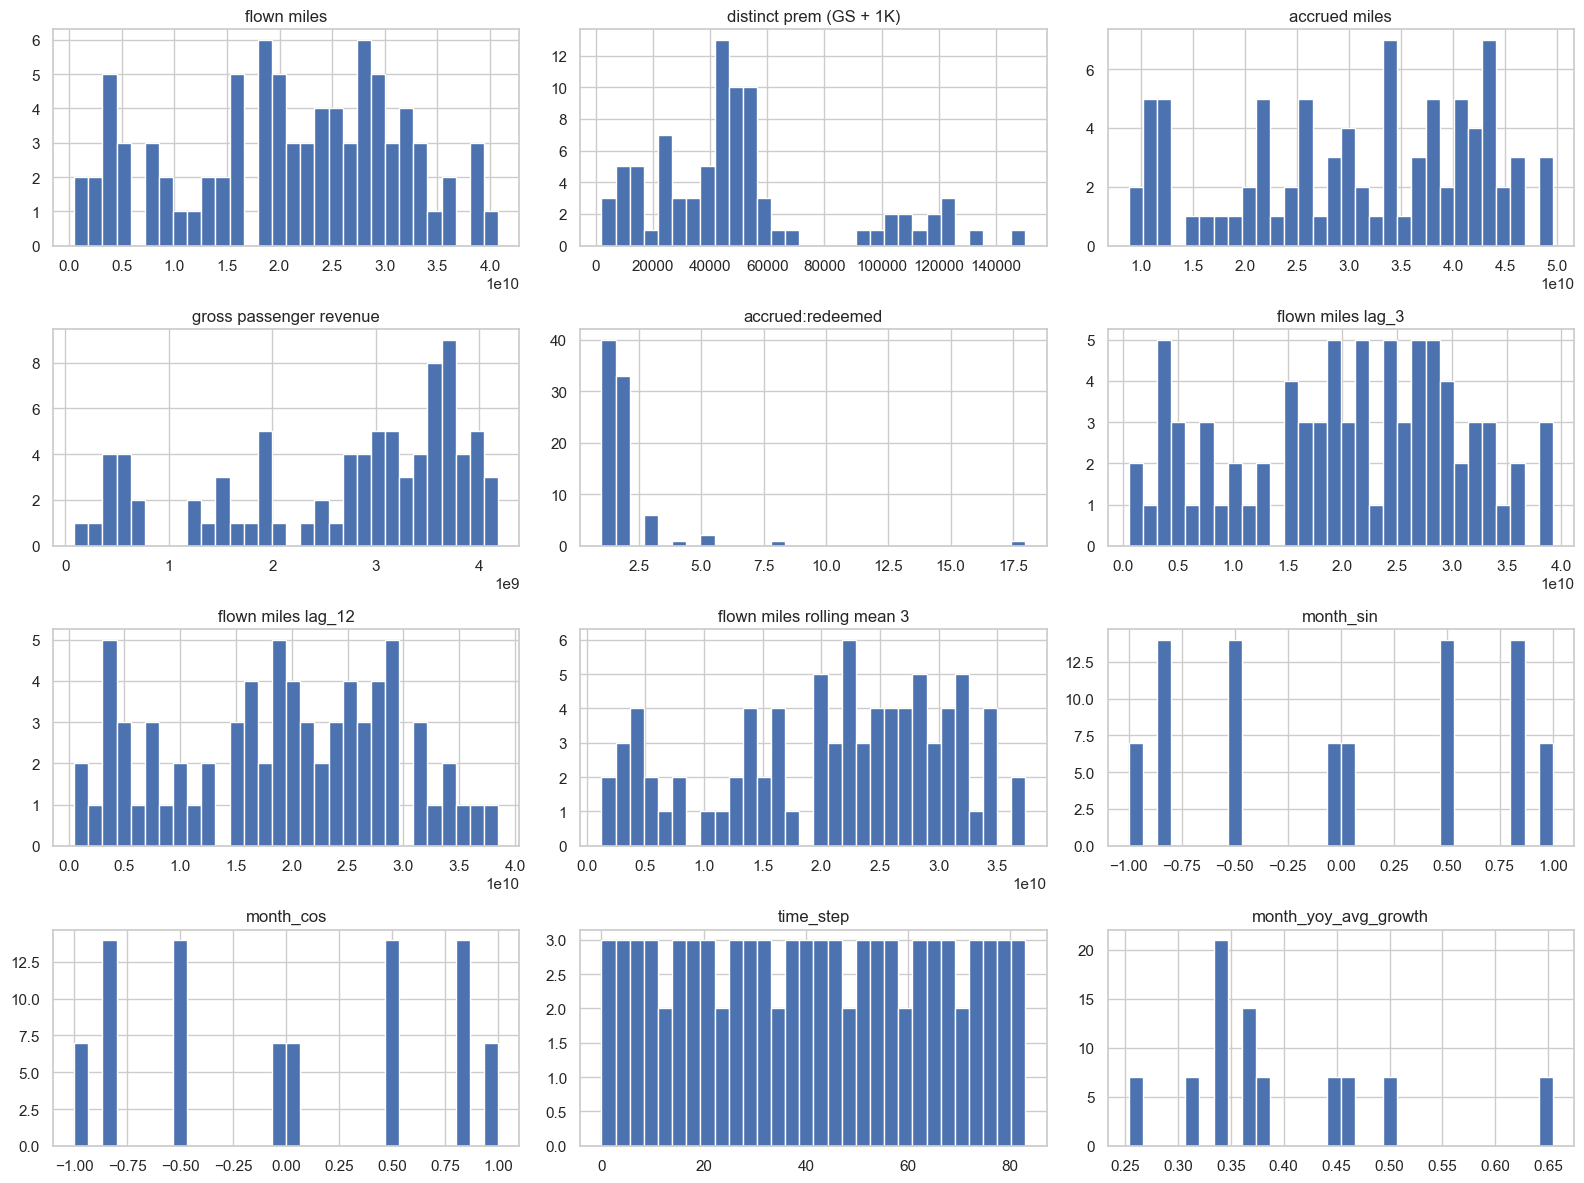

In [ ]:
# Distribution of key features to check for skewness and outliers
current_numeric_cols = df.select_dtypes(include=np.number).columns
df[current_numeric_cols].hist(bins=30, figsize=(16,12))
plt.tight_layout()
plt.show()

Implementing the XG Boost model (Test 1---> with a:r ratio even though it's very risky)

In [110]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [111]:
TARGET = "flown miles"
FEATURES = ["distinct prem (GS + 1K)",
    "accrued miles",
    "gross passenger revenue",
    "accrued:redeemed",
    "flown miles lag_3",
    "flown miles lag_12",
    "flown miles rolling mean 3",
    "month_sin",
    "month_cos",
    "time_step",
    "month_yoy_avg_growth"]

In [112]:
df_model = df[FEATURES + [TARGET]].dropna().reset_index(drop=True)
print("Rows available for modeling:", df_model.shape[0])

Rows available for modeling: 72


In [113]:
def walk_forward_split(df, train_size):
    train = df.iloc[:train_size]
    test = df.iloc[train_size:train_size + 1]
    return train, test

Defining hyperparams ---> can change later

In [114]:
xgb_model = XGBRegressor(
    n_estimators=300,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42)

Making pred using past months

In [115]:
predictions = []
actuals = []
initial_train_size = 36
for i in range(initial_train_size, len(df_model)):
    train, test = walk_forward_split(df_model, i)
    X_train = train[FEATURES]
    y_train = train[TARGET]
    X_test = test[FEATURES]
    y_test = test[TARGET]
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)[0]
    predictions.append(y_pred)
    actuals.append(y_test.values[0])

Evals

In [116]:
mae = mean_absolute_error(actuals, predictions)
mse = mean_squared_error(actuals, predictions)
rmse = np.sqrt(mse)
print(f"MAE:  {mae:,.0f}")
print(f"RMSE: {rmse:,.0f}")

MAE:  1,985,166,822
RMSE: 2,465,657,161


In [117]:
#turning it into a percerntage error
actuals_arr = np.array(actuals)
preds_arr = np.array(predictions)
mape = np.mean(np.abs((actuals_arr - preds_arr) / actuals_arr)) * 100
print(f"MAPE: {mape:.2f}%")

MAPE: 6.82%


Retraining

In [118]:
final_model = XGBRegressor(
    n_estimators=300,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42)
final_model.fit(df_model[FEATURES], df_model[TARGET])

,"objective objective: str | xgboost.sklearn._SklObjWProto | typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]] | NoneSpecify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: float | typing.List[float] | NoneThe initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.List[xgboost.callback.TrainingCallback] | NoneList of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: float | NoneSubsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: float | NoneSubsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: float | NoneSubsample ratio of columns when constructing each tree.,0.8
,"device device: str | None.. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: int | None.. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: str | typing.List[str | typing.Callable] | typing.Callable | None.. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes from sklearn.metrics import mean_absolute_error X, y = load_diabetes(return_X_y=True) reg = xgb.XGBRegressor( tree_meth

Forecasting for the next 12 months rolling

In [119]:
future_preds = []
df_future = df_model.copy()
for h in range(12):
    X_next = df_future[FEATURES].iloc[[-1]]
    next_pred = final_model.predict(X_next)[0]
    future_preds.append(next_pred)

    new_row = df_future.iloc[-1].copy()
    new_row[TARGET] = next_pred

    # Correct lag shifting
    new_row["flown miles lag_12"] = df_future[TARGET].iloc[-12]
    new_row["flown miles lag_6"]  = df_future[TARGET].iloc[-6]
    new_row["flown miles lag_3"]  = df_future[TARGET].iloc[-3]

    # Rolling mean (last 2 actual/pred + new pred)
    new_row["flown miles rolling mean 3"] = (
        df_future[TARGET].iloc[-2:].mean() + next_pred
    ) / 2

    # Time progression
    new_row["time_step"] += 1

    # Calendar progression
    next_month = pd.to_datetime(new_row.name) if isinstance(new_row.name, pd.Timestamp) else None

    df_future = pd.concat(
        [df_future, new_row.to_frame().T],
        ignore_index=True
    )

In [120]:
forecast_df = pd.DataFrame({
    "horizon_month": range(1, 13),
    "forecast_flown_miles": future_preds})
forecast_df

,horizon_month,forecast_flown_miles
0,1,4.058367e+10
1,2,3.214078e+10
2,3,3.144560e+10
3,4,3.473272e+10
4,5,3.473281e+10
5,6,3.686971e+10
6,7,4.008681e+10
7,8,3.949223e+10
8,9,3.829648e+10
9,10,3.457160e+10


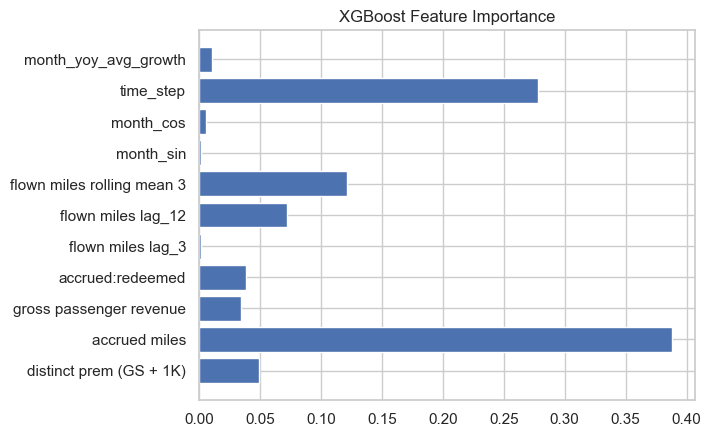

In [121]:
#just testing some important features importance to understand which features are driving the predictions the most
plt.barh(FEATURES, final_model.feature_importances_)
plt.title("XGBoost Feature Importance")
plt.show()

Backtest vs Actuals

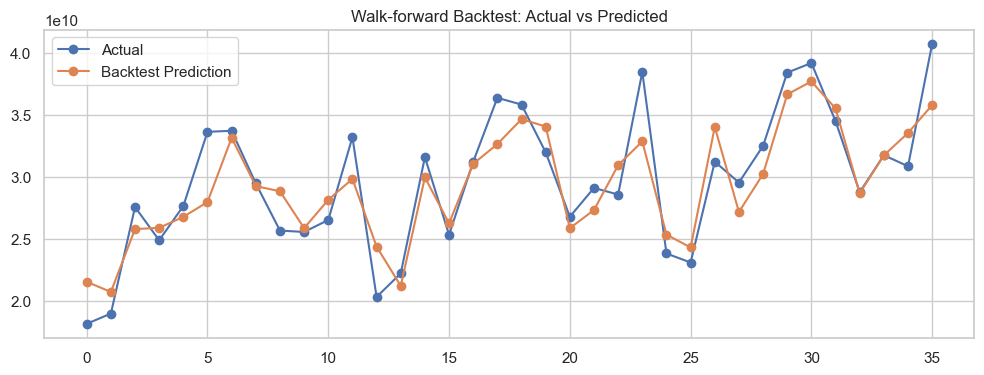

In [122]:
plt.figure(figsize=(12,4))
plt.plot(actuals, label="Actual", marker="o")
plt.plot(predictions, label="Backtest Prediction", marker="o")
plt.legend()
plt.title("Walk-forward Backtest: Actual vs Predicted")
plt.grid(True)
plt.show()

Backtest pred vs actuals vs forecasted

In [123]:
# Lengths
n_total = len(df_model)
n_backtest = len(predictions)
n_forecast = len(future_preds)

# X-axis indices
actual_x = np.arange(n_total)
backtest_x = np.arange(n_total - n_backtest, n_total)
forecast_x = np.arange(n_total, n_total + n_forecast)

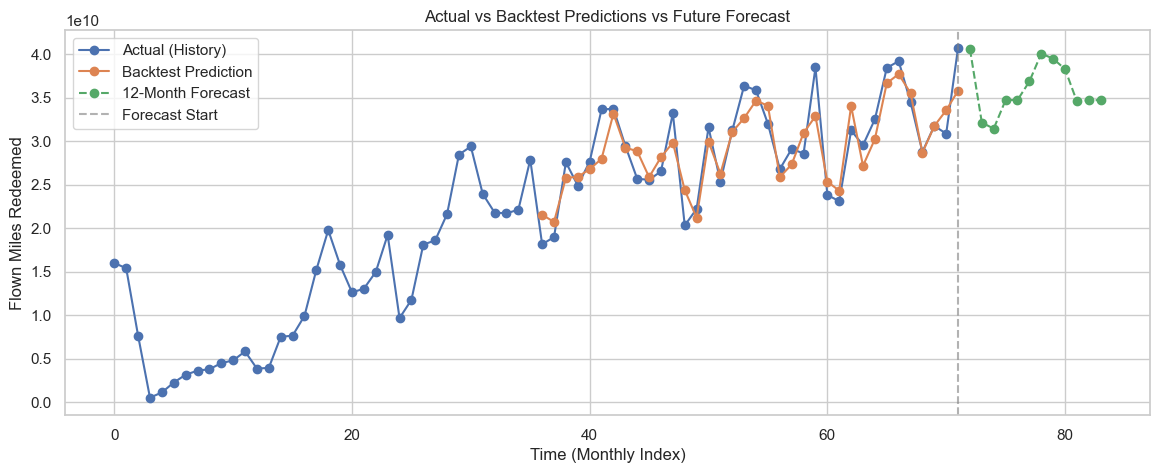

In [124]:
plt.figure(figsize=(14,5))
# Historical actuals
plt.plot(actual_x, df_model[TARGET].values, label="Actual (History)", marker="o")

# Walk-forward backtest predictions
plt.plot(backtest_x, predictions, label="Backtest Prediction", marker="o")

# Future forecasts
plt.plot(forecast_x, future_preds, label="12-Month Forecast", marker="o", linestyle="--")

# Visual separator for forecast start
plt.axvline(x=n_total - 1, color="gray",linestyle="--", alpha=0.6,label="Forecast Start")

plt.title("Actual vs Backtest Predictions vs Future Forecast")
plt.xlabel("Time (Monthly Index)")
plt.ylabel("Flown Miles Redeemed")
plt.legend()
plt.grid(True)
plt.show()